In [1]:
%pylab inline
try:
    reload(galpy.df)
except NameError:
    import galpy.df
import os, os.path
from scipy import interpolate
from galpy.orbit import Orbit
from galpy.potential import LogarithmicHaloPotential
from galpy.actionAngle import actionAngleIsochroneApprox, estimateBIsochrone
from galpy.df import streamdf
from galpy.util import bovy_plot, bovy_coords, bovy_conversion #for unit conversions

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
#a = sns.plotting_context('ipython')
sns.set_style('ticks',
              {'xtick.direction': u'in',
               'ytick.direction': u'in',
               'axes.labelsize': 18.0,
               'axes.titlesize': 18.0,
               'figure.figsize': array([ 6.64,  4.  ]),
               'grid.linewidth': 2.0,
               'legend.fontsize': 18.0,
               'lines.linewidth': 2.0,
               'lines.markeredgewidth': 0.0,
               'lines.markersize': 14.0,
               'patch.linewidth': 0.6,
               'xtick.labelsize': 16.0,
               'xtick.major.pad': 14.0,
               'xtick.major.width': 2.0,
               'xtick.minor.width': 1.0,
               'ytick.labelsize': 16.0,
               'ytick.major.pad': 14.0,
               'ytick.major.width': 2.0,})

# A *galpy* model of the gap in Denis' simulation

# Modeling the unperturbed stream

The background potential

In [3]:
lp= LogarithmicHaloPotential(normalize=1.,q=0.9)

We'll normalize positions and velocities using the following scales:

In [4]:
R0, V0= 8., 220.

Quick function to convert a snapshot to cylindrical coordinates

In [5]:
def convert_to_cylindrical(xv):
    R,phi,Z= bovy_coords.rect_to_cyl(xv[:,0],xv[:,1],xv[:,2])
    vR,vT,vZ= bovy_coords.rect_to_cyl_vec(xv[:,3],xv[:,4],xv[:,5],R,phi,Z,cyl=True)
    out= numpy.empty_like(xv)
    # Preferred galpy arrangement of cylindrical coordinates
    out[:,0]= R
    out[:,1]= vR
    out[:,2]= vT
    out[:,3]= Z
    out[:,4]= vZ
    out[:,5]= phi
    return out

We start from the progenitor's original position integrated forward in time to figure out the current phase-space position

In [6]:
xv_prog_init= numpy.array([30.,0.,0.,0., 105.74895, 105.74895])
RvR_prog_init= convert_to_cylindrical(xv_prog_init[:,numpy.newaxis].T)[0,:]

In [7]:
prog_init= Orbit([RvR_prog_init[0]/R0,RvR_prog_init[1]/V0,RvR_prog_init[2]/V0,
                  RvR_prog_init[3]/R0,RvR_prog_init[4]/V0,RvR_prog_init[5]],ro=R0,vo=V0)
times= numpy.linspace(0.,10.88/bovy_conversion.time_in_Gyr(V0,R0),1001)
prog_init.integrate(times,lp)
xv_unp_peri_prog= [prog_init.x(times[-1])[0],prog_init.y(times[-1])[0],prog_init.z(times[-1]),
              prog_init.vx(times[-1])[0],prog_init.vy(times[-1])[0],prog_init.vz(times[-1])]

Now we load the current snapshot and sort it by particle ID for later

In [8]:
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','snapshot_2nd_peri_unperturbed.txt'))
xv_unp_peri= xvid[:,:6]
xv_unp_peri= xv_unp_peri[numpy.argsort(xvid[:,6])]

Let's compare the median of the snapshot to the current position of the progenitor that we calculated above

In [9]:
print numpy.median(xv_unp_peri,axis=0), xv_unp_peri_prog

[  20.617455     5.039721   -16.088234    11.298809   156.243179
  -72.4251975] [20.624926997104502, 5.0950045522192191, -16.114716519179737, 10.828156330627257, 156.49209358413074, -72.022229017296226]


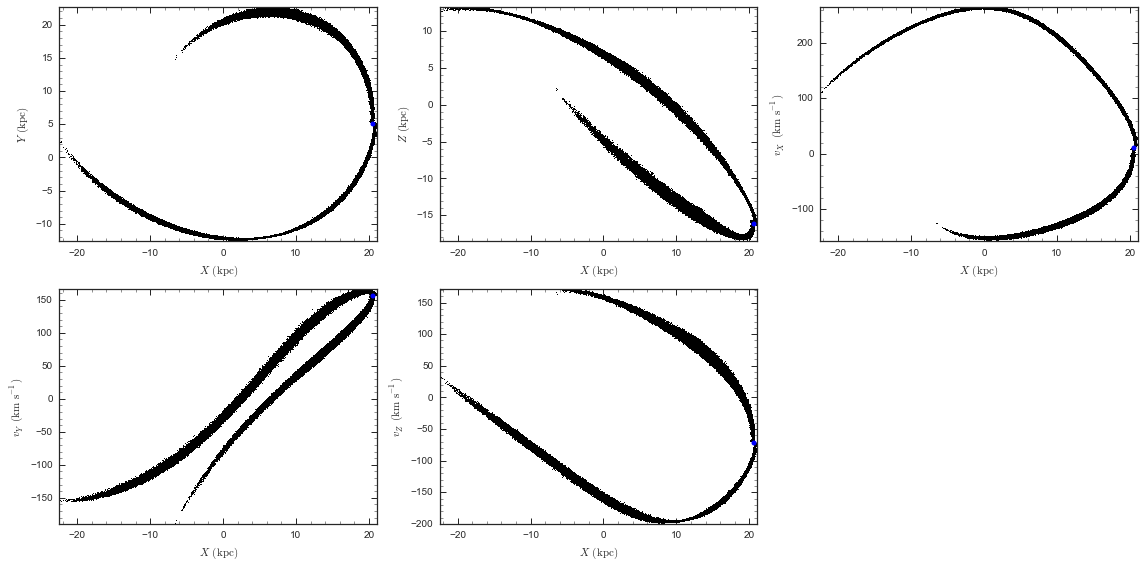

In [10]:
figsize(16,8)
subplot(2,3,1)
bovy_plot.bovy_plot(xv_unp_peri[:,0],xv_unp_peri[:,1],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Y\,(\mathrm{kpc})$',gcf=True)
bovy_plot.bovy_plot(xv_unp_peri_prog[0],xv_unp_peri_prog[1],'bo',ms=5.,overplot=True)
subplot(2,3,2)
bovy_plot.bovy_plot(xv_unp_peri[:,0],xv_unp_peri[:,2],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Z\,(\mathrm{kpc})$',gcf=True)
bovy_plot.bovy_plot(xv_unp_peri_prog[0],xv_unp_peri_prog[2],'bo',ms=5.,overplot=True)
subplot(2,3,3)
bovy_plot.bovy_plot(xv_unp_peri[:,0],xv_unp_peri[:,3],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$v_X\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(xv_unp_peri_prog[0],xv_unp_peri_prog[3],'bo',ms=5.,overplot=True)
subplot(2,3,4)
bovy_plot.bovy_plot(xv_unp_peri[:,0],xv_unp_peri[:,4],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$v_Y\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(xv_unp_peri_prog[0],xv_unp_peri_prog[4],'bo',ms=5.,overplot=True)
subplot(2,3,5)
bovy_plot.bovy_plot(xv_unp_peri[:,0],xv_unp_peri[:,5],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$v_Z\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(xv_unp_peri_prog[0],xv_unp_peri_prog[5],'bo',ms=5.,overplot=True)
tight_layout()

In [11]:
RvR_unp_peri= convert_to_cylindrical(xv_unp_peri)
RvR_unp_peri_prog= convert_to_cylindrical(numpy.array(xv_unp_peri_prog)[:,numpy.newaxis].T)[0,:]

Snapshot plots in cylindrical coordinates

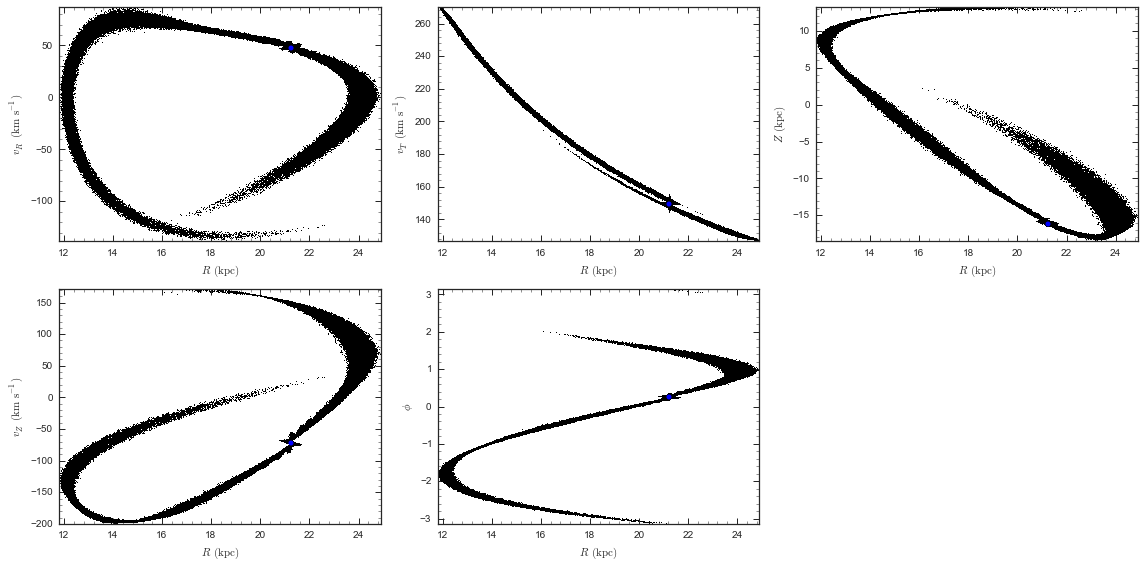

In [12]:
figsize(16,8)
subplot(2,3,1)
bovy_plot.bovy_plot(RvR_unp_peri[:,0],RvR_unp_peri[:,1],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$v_R\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(RvR_unp_peri_prog[0],RvR_unp_peri_prog[1],'bo',ms=5.,overplot=True)
subplot(2,3,2)
bovy_plot.bovy_plot(RvR_unp_peri[:,0],RvR_unp_peri[:,2],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$v_T\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(RvR_unp_peri_prog[0],RvR_unp_peri_prog[2],'bo',ms=5.,overplot=True)
subplot(2,3,3)
bovy_plot.bovy_plot(RvR_unp_peri[:,0],RvR_unp_peri[:,3],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$Z\,(\mathrm{kpc})$',gcf=True)
bovy_plot.bovy_plot(RvR_unp_peri_prog[0],RvR_unp_peri_prog[3],'bo',ms=5.,overplot=True)
subplot(2,3,4)
bovy_plot.bovy_plot(RvR_unp_peri[:,0],RvR_unp_peri[:,4],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$v_Z\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(RvR_unp_peri_prog[0],RvR_unp_peri_prog[4],'bo',ms=5.,overplot=True)
subplot(2,3,5)
bovy_plot.bovy_plot(RvR_unp_peri[:,0],RvR_unp_peri[:,5],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$\phi$',gcf=True)
bovy_plot.bovy_plot(RvR_unp_peri_prog[0],RvR_unp_peri_prog[5],'bo',ms=5.,overplot=True)
tight_layout()

Now we setup a *galpy* model for the unperturbed stream

In [13]:
prog_unp_peri= Orbit([RvR_unp_peri_prog[0]/R0,RvR_unp_peri_prog[1]/V0,RvR_unp_peri_prog[2]/V0,
                      RvR_unp_peri_prog[3]/R0+0.0,RvR_unp_peri_prog[4]/V0,RvR_unp_peri_prog[5]]) # Normalized coordinates

We'll integrate this orbit to find a good isochrone auxiliary potential for the action-angle driver

In [14]:
ts= numpy.linspace(0.,100.,1001)
prog_unp_peri.integrate(ts,lp)
estimateBIsochrone(prog_unp_peri.R(ts),prog_unp_peri.z(ts),pot=lp)

(0.75649266398566906, 1.3897492117801131, 1.7096377875748467)

In [15]:
aAI= actionAngleIsochroneApprox(pot=lp,b=0.8)

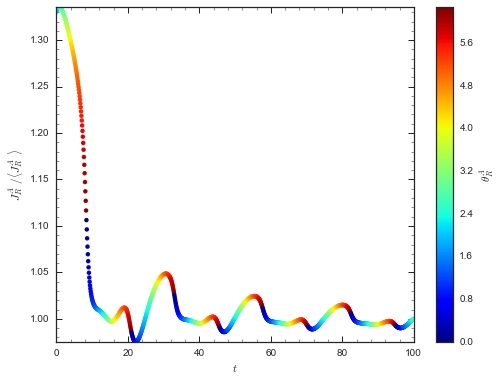

In [16]:
figsize(8,6)
aAI.plot(prog_unp_peri,type='jr',cmap='jet')

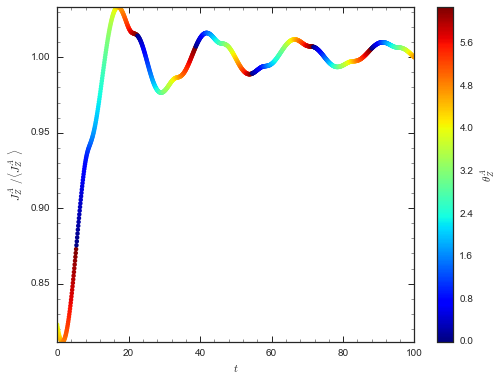

In [17]:
figsize(8,6)
aAI.plot(prog_unp_peri,type='jz',cmap='jet')

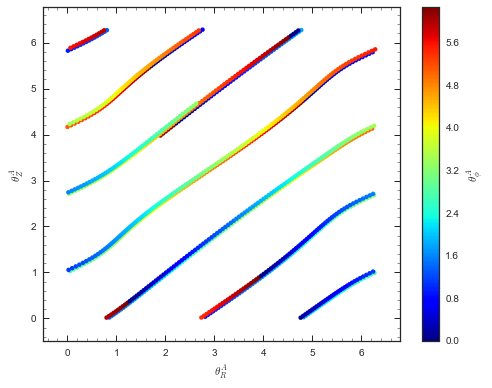

In [18]:
figsize(8,6)
aAI.plot(prog_unp_peri,type='araz',cmap='jet')

In [19]:
sigv= 0.365*(10./2.)**(1./3.) # km/s, based on M^(1/3) scaling applied to 10^5 vs. 2x10^4 in my paper

In [20]:
sdfl_unp_peri= streamdf(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                        leading=False,nTrackChunks=26,nTrackIterations=1,
                        sigMeanOffset=4.5,
                        tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                        Vnorm=V0,Rnorm=R0)

Check the calculation of the stream track:

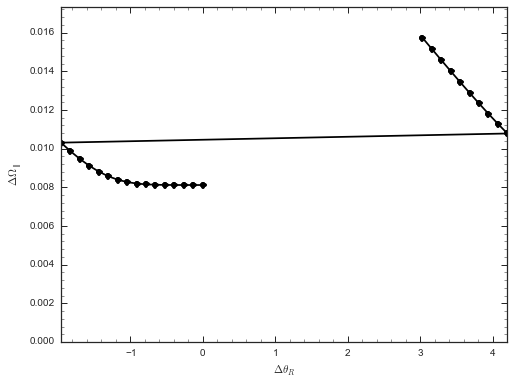

In [21]:
figsize(8,6)
sdfl_unp_peri.plotCompareTrackAAModel()

Stream track vs. the simulation:

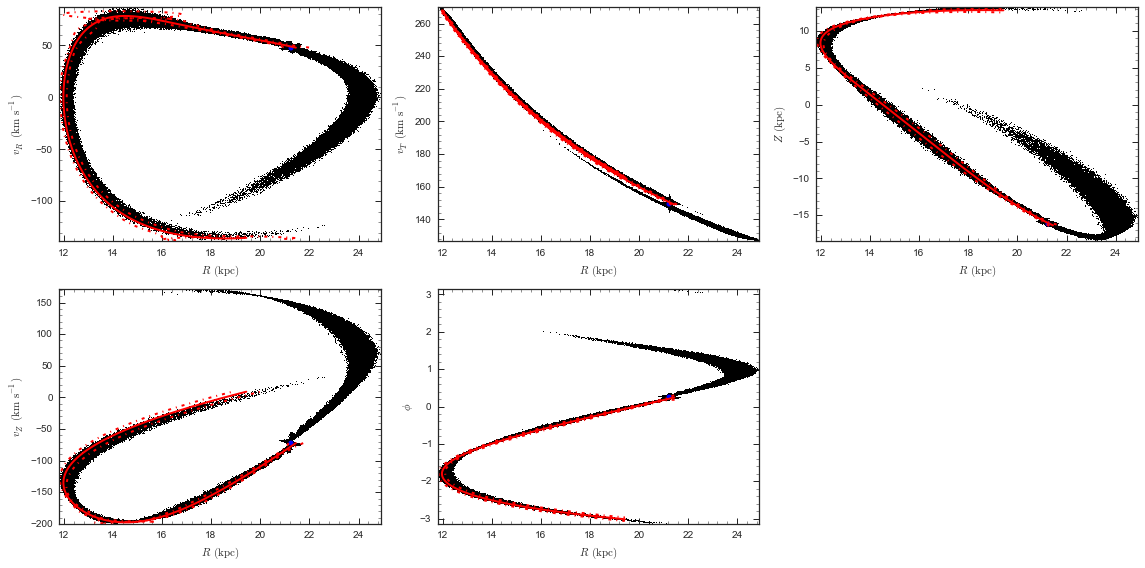

In [22]:
figsize(16,8)
subplot(2,3,1)
bovy_plot.bovy_plot(RvR_unp_peri[:,0],RvR_unp_peri[:,1],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$v_R\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(RvR_unp_peri_prog[0],RvR_unp_peri_prog[1],'bo',ms=5.,overplot=True)
sdfl_unp_peri.plotTrack(d1='R',d2='vR',interp=True,color='r',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
subplot(2,3,2)
bovy_plot.bovy_plot(RvR_unp_peri[:,0],RvR_unp_peri[:,2],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$v_T\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(RvR_unp_peri_prog[0],RvR_unp_peri_prog[2],'bo',ms=5.,overplot=True)
sdfl_unp_peri.plotTrack(d1='R',d2='vT',interp=True,color='r',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
subplot(2,3,3)
bovy_plot.bovy_plot(RvR_unp_peri[:,0],RvR_unp_peri[:,3],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$Z\,(\mathrm{kpc})$',gcf=True)
bovy_plot.bovy_plot(RvR_unp_peri_prog[0],RvR_unp_peri_prog[3],'bo',ms=5.,overplot=True)
sdfl_unp_peri.plotTrack(d1='R',d2='Z',interp=True,color='r',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
subplot(2,3,4)
bovy_plot.bovy_plot(RvR_unp_peri[:,0],RvR_unp_peri[:,4],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$v_Z\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(RvR_unp_peri_prog[0],RvR_unp_peri_prog[4],'bo',ms=5.,overplot=True)
sdfl_unp_peri.plotTrack(d1='R',d2='vZ',interp=True,color='r',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
subplot(2,3,5)
bovy_plot.bovy_plot(RvR_unp_peri[:,0],RvR_unp_peri[:,5],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$\phi$',gcf=True)
bovy_plot.bovy_plot(RvR_unp_peri_prog[0],RvR_unp_peri_prog[5],'bo',ms=5.,overplot=True)
sdfl_unp_peri.plotTrack(d1='R',d2='phi',interp=True,color='r',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
tight_layout()

That looks pretty good! Remember that we only modeled the leading stream...

## Modeling the perturbed stream

We will now build a model of the perturbed stream, starting from the model for the unperturbed stream. First we read Denis' file with the point of closest approach, to figure out the angle difference between the progenitor at this point

In [23]:
xv_impact= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','gap_location_impact.txt'))[:6]
RvR_impact= convert_to_cylindrical(xv_impact[:,numpy.newaxis].T)[0,:]
xv_gap= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','gap_location_2nd_peri.txt'))[:6]
RvR_gap= convert_to_cylindrical(xv_gap[:,numpy.newaxis].T)[0,:]

In [24]:
aA_impact= aAI.actionsFreqsAngles(RvR_impact[0]/R0,RvR_impact[1]/V0,RvR_impact[2]/V0,
                                  RvR_impact[3]/R0+10.**-4.,RvR_impact[4]/V0,RvR_impact[5]) # HACK for zero Jz

The angle difference wrt the progenitor at the time of impact is

In [25]:
dar= aA_impact[6]-(sdfl_unp_peri._progenitor_angler-sdfl_unp_peri._progenitor_Omegar*0.88/bovy_conversion.time_in_Gyr(V0,R0))-4.*numpy.pi
daphi= aA_impact[7]-(sdfl_unp_peri._progenitor_anglephi-sdfl_unp_peri._progenitor_Omegaphi*0.88/bovy_conversion.time_in_Gyr(V0,R0))-2.*numpy.pi
daz= aA_impact[8]-(sdfl_unp_peri._progenitor_anglez-sdfl_unp_peri._progenitor_Omegaz*0.88/bovy_conversion.time_in_Gyr(V0,R0))-4.*numpy.pi
daperp= numpy.dot(numpy.array([dar[0],daphi[0],daz[0]]),sdfl_unp_peri._dsigomeanProgDirection)
print "angle offset from progenitor is %f" % (-daperp)

angle offset from progenitor is -2.349189


Alternatively, we can start from the progenitor at impact. First we load the unperturbed stream at impact

In [26]:
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','snapshot_impact_unperturbed.txt'))
xv_unp_impact= xvid[:,:6]
RvR_unp_impact= convert_to_cylindrical(xv_unp_impact)

The progenitor is then

In [27]:
xv_unp_impact_prog= numpy.median(xv_unp_impact,axis=0)
RvR_impact_prog= convert_to_cylindrical(xv_unp_impact_prog[:,numpy.newaxis].T)[0,:]
aA_impact_prog= aAI.actionsFreqsAngles(RvR_impact_prog[0]/R0,RvR_impact_prog[1]/V0,RvR_impact_prog[2]/V0,
                                  RvR_impact_prog[3]/R0+10.**-4.,RvR_impact_prog[4]/V0,RvR_impact_prog[5]) # HACK for zero Jz

In [28]:
dar= aA_impact[6]-aA_impact_prog[6]
daphi= aA_impact[7]-aA_impact_prog[7]
daz= aA_impact[8]-aA_impact_prog[8]-2.*numpy.pi
daperp= numpy.dot(numpy.array([dar[0],daphi[0],daz[0]]),sdfl_unp_peri._dsigomeanProgDirection)
print "angle offset from progenitor is %f" % (-daperp)

angle offset from progenitor is -2.342917


Now we set up a model for the $M = 10^8\,M_\odot$ impact

In [29]:
try:
    reload(galpy.df)
except NameError:
    import galpy.df

In [30]:
sdfl_per_1e8_peri= galpy.df.streamgapdf(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                        leading=False,nTrackChunks=26,nTrackIterations=1,
                                        sigMeanOffset=4.5,
                                        tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                        Vnorm=V0,Rnorm=R0,
                                        impactb=0.,
                                        subhalovel=numpy.array([6.82200571,132.7700529,149.4174464])/V0, # from Denis' email
                                        timpact=0.88/bovy_conversion.time_in_Gyr(V0,R0),
                                        impact_angle=-2.34,
                                        GM=10.**-2./bovy_conversion.mass_in_1010msol(V0,R0),
                                        rs=0.625/R0)                                 

Check the calculation of the track

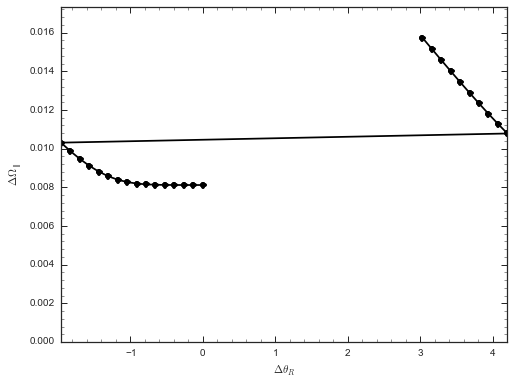

In [31]:
figsize(8,6)
sdfl_per_1e8_peri.plotCompareTrackAAModel()

Now we're going into the development zone, so we'll just start using the private attributes of the streamgapdf object. The track near the impact is

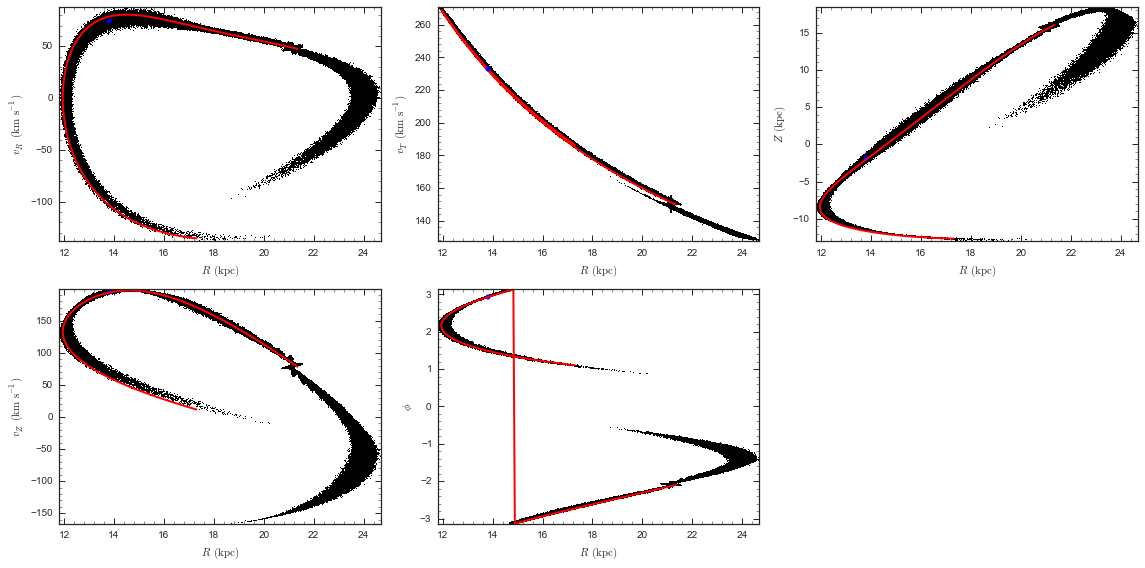

In [32]:
figsize(16,8)
subplot(2,3,1)
bovy_plot.bovy_plot(RvR_unp_impact[:,0],RvR_unp_impact[:,1],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$v_R\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(RvR_impact[0],RvR_impact[1],'bo',ms=5.,overplot=True)
plot(sdfl_per_1e8_peri._kick_interpolatedObsTrack[:,0]*R0,sdfl_per_1e8_peri._kick_interpolatedObsTrack[:,1]*V0,
     'r-',lw=2.)
subplot(2,3,2)
bovy_plot.bovy_plot(RvR_unp_impact[:,0],RvR_unp_impact[:,2],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$v_T\,(\mathrm{km\,s}^{-1})$',gcf=True)
plot(sdfl_per_1e8_peri._kick_interpolatedObsTrack[:,0]*R0,sdfl_per_1e8_peri._kick_interpolatedObsTrack[:,2]*V0,
     'r-',lw=2.)
bovy_plot.bovy_plot(RvR_impact[0],RvR_impact[2],'bo',ms=5.,overplot=True)
subplot(2,3,3)
bovy_plot.bovy_plot(RvR_unp_impact[:,0],RvR_unp_impact[:,3],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$Z\,(\mathrm{kpc})$',gcf=True)
bovy_plot.bovy_plot(RvR_impact[0],RvR_impact[3],'bo',ms=5.,overplot=True)
plot(sdfl_per_1e8_peri._kick_interpolatedObsTrack[:,0]*R0,sdfl_per_1e8_peri._kick_interpolatedObsTrack[:,3]*R0,
     'r-',lw=2.)
subplot(2,3,4)
bovy_plot.bovy_plot(RvR_unp_impact[:,0],RvR_unp_impact[:,4],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$v_Z\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(RvR_impact[0],RvR_impact[4],'bo',ms=5.,overplot=True)
plot(sdfl_per_1e8_peri._kick_interpolatedObsTrack[:,0]*R0,sdfl_per_1e8_peri._kick_interpolatedObsTrack[:,4]*V0,
     'r-',lw=2.)

subplot(2,3,5)
bovy_plot.bovy_plot(RvR_unp_impact[:,0],RvR_unp_impact[:,5],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$\phi$',gcf=True)
bovy_plot.bovy_plot(RvR_impact[0],RvR_impact[5],'bo',ms=5.,overplot=True)
plot(sdfl_per_1e8_peri._kick_interpolatedObsTrack[:,0]*R0,sdfl_per_1e8_peri._kick_interpolatedObsTrack[:,5],
     'r-',lw=2.)

tight_layout()

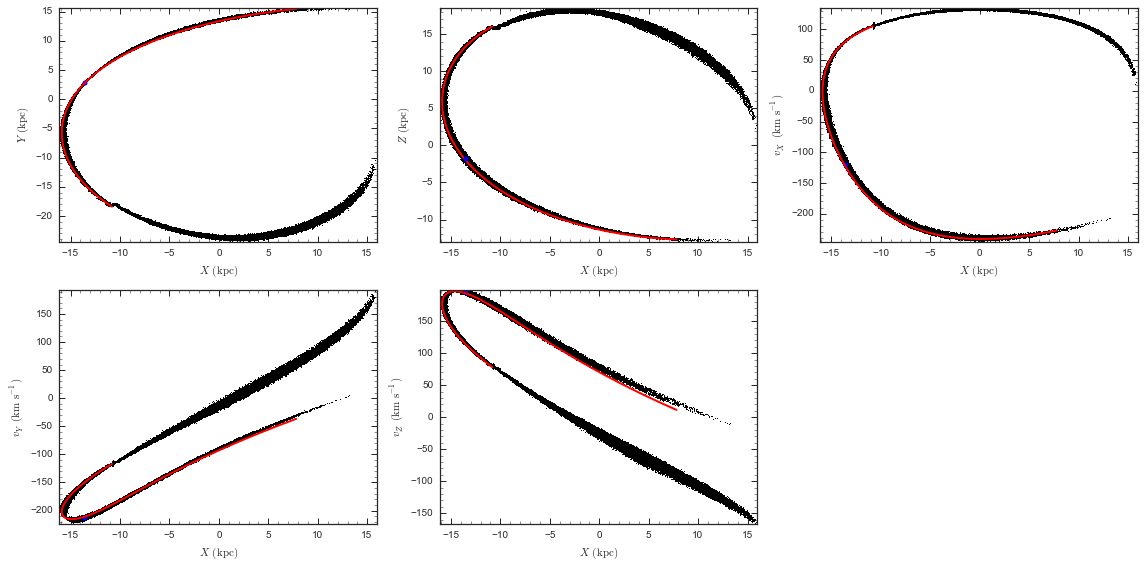

In [33]:
figsize(16,8)
subplot(2,3,1)
bovy_plot.bovy_plot(xv_unp_impact[:,0],xv_unp_impact[:,1],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Y\,(\mathrm{kpc})$',gcf=True)
bovy_plot.bovy_plot(xv_impact[0],xv_impact[1],'bo',ms=5.,overplot=True)
plot(sdfl_per_1e8_peri._kick_interpolatedObsTrackXY[:,0]*R0,sdfl_per_1e8_peri._kick_interpolatedObsTrackXY[:,1]*R0,
     'r-',lw=2.)
subplot(2,3,2)
bovy_plot.bovy_plot(xv_unp_impact[:,0],xv_unp_impact[:,2],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Z\,(\mathrm{kpc})$',gcf=True)
plot(sdfl_per_1e8_peri._kick_interpolatedObsTrackXY[:,0]*R0,sdfl_per_1e8_peri._kick_interpolatedObsTrackXY[:,2]*R0,
     'r-',lw=2.)
bovy_plot.bovy_plot(xv_impact[0],xv_impact[2],'bo',ms=5.,overplot=True)
subplot(2,3,3)
bovy_plot.bovy_plot(xv_unp_impact[:,0],xv_unp_impact[:,3],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$v_X\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(xv_impact[0],xv_impact[3],'bo',ms=5.,overplot=True)
plot(sdfl_per_1e8_peri._kick_interpolatedObsTrackXY[:,0]*R0,sdfl_per_1e8_peri._kick_interpolatedObsTrackXY[:,3]*V0,
     'r-',lw=2.)
subplot(2,3,4)
bovy_plot.bovy_plot(xv_unp_impact[:,0],xv_unp_impact[:,4],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$v_Y\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(xv_impact[0],xv_impact[4],'bo',ms=5.,overplot=True)
plot(sdfl_per_1e8_peri._kick_interpolatedObsTrackXY[:,0]*R0,sdfl_per_1e8_peri._kick_interpolatedObsTrackXY[:,4]*V0,
     'r-',lw=2.)
subplot(2,3,5)
bovy_plot.bovy_plot(xv_unp_impact[:,0],xv_unp_impact[:,5],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$v_Z\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(xv_impact[0],xv_impact[5],'bo',ms=5.,overplot=True)
plot(sdfl_per_1e8_peri._kick_interpolatedObsTrackXY[:,0]*R0,sdfl_per_1e8_peri._kick_interpolatedObsTrackXY[:,5]*V0,
     'r-',lw=2.)
tight_layout()

That looks okay. Let's look at the velocity kicks

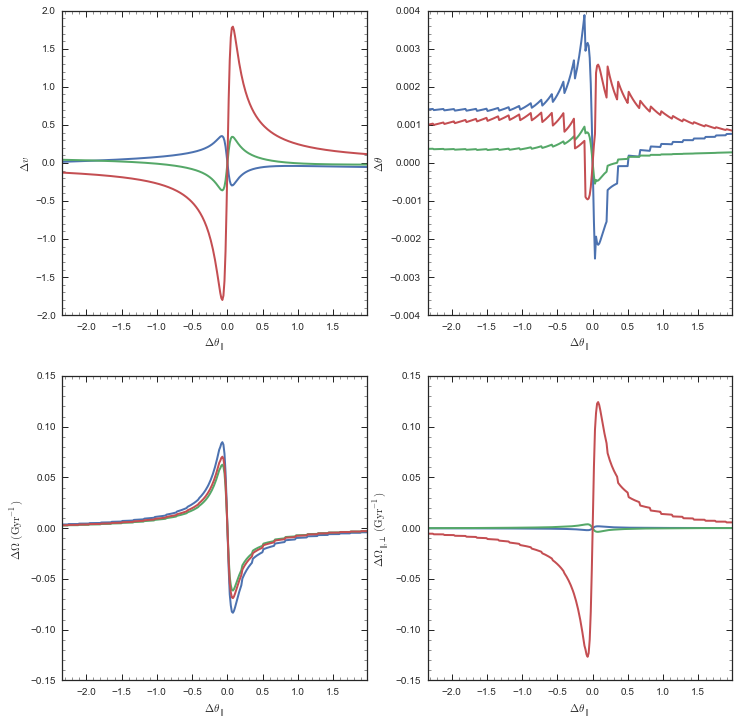

In [34]:
figsize(12,12)
subplot(2,2,1)
bovy_plot.bovy_plot(sdfl_per_1e8_peri._kick_interpolatedThetasTrack-sdfl_per_1e8_peri._impact_angle,
                    sdfl_per_1e8_peri._kick_deltav*V0,'-',lw=2.,
                    xlabel=r'$\Delta \theta_\parallel$',ylabel=r'$\Delta v$',
                    yrange=[-2.,2.],gcf=True)
subplot(2,2,2)
bovy_plot.bovy_plot(sdfl_per_1e8_peri._kick_interpolatedThetasTrack-sdfl_per_1e8_peri._impact_angle,
                    sdfl_per_1e8_peri._kick_dOap[:,3:],'-',lw=2.,
                    xlabel=r'$\Delta \theta_\parallel$',ylabel=r'$\Delta \theta$',
                    yrange=[-0.004,0.004],gcf=True)
subplot(2,2,3)
bovy_plot.bovy_plot(sdfl_per_1e8_peri._kick_interpolatedThetasTrack-sdfl_per_1e8_peri._impact_angle,
                    sdfl_per_1e8_peri._kick_dOap[:,:3]*bovy_conversion.freq_in_Gyr(V0,R0),'-',lw=2.,
                    xlabel=r'$\Delta \theta_\parallel$',ylabel=r'$\Delta \Omega\,(\mathrm{Gyr}^{-1})$',
                    yrange=[-0.15,0.15],gcf=True)
subplot(2,2,4)
bovy_plot.bovy_plot(sdfl_per_1e8_peri._kick_interpolatedThetasTrack-sdfl_per_1e8_peri._impact_angle,
                    sdfl_per_1e8_peri._kick_dOaparperp*bovy_conversion.freq_in_Gyr(V0,R0),'-',lw=2.,
                    xlabel=r'$\Delta \theta_\parallel$',ylabel=r'$\Delta \Omega_{\parallel,\perp}\,(\mathrm{Gyr}^{-1})$',
                    yrange=[-0.15,0.15],gcf=True)
#bovy_plot.bovy_plot(sdfl_per_1e8_peri._kick_interpolatedThetasTrack+sdfl_per_1e8_peri._impact_angle,
#                    sdfl_per_1e8_peri._kick_interpdOpar(sdfl_per_1e8_peri._kick_interpolatedThetasTrack)*bovy_conversion.freq_in_Gyr(V0,R0),'-',lw=2.,
#                    overplot=True)

The rewound angles are different from backwards linear evolution at the mean frequency offset by the following amount:

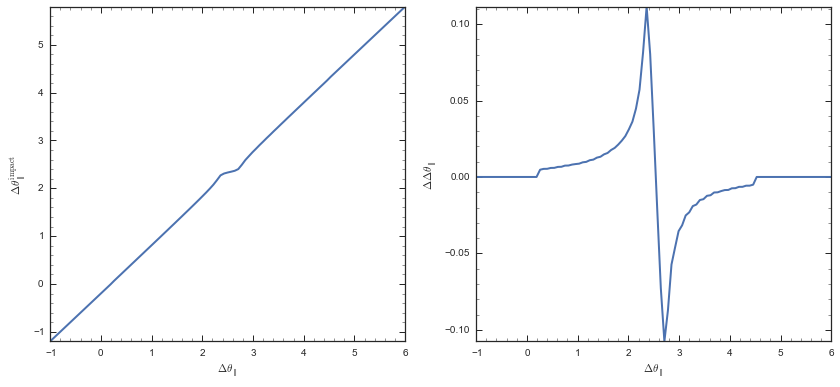

In [35]:
figsize(14,6)
subplot(1,2,1)
xs= numpy.linspace(-1.,6.,101)
bovy_plot.bovy_plot(xs,
                    [sdfl_per_1e8_peri._rewind_angle_impact(x) for x in xs],
                    '-',lw=2.,gcf=True,
                    xlabel=r'$\Delta \theta_\parallel$',ylabel=r'$\Delta \theta_\parallel^\mathrm{impact}$')
subplot(1,2,2)
bovy_plot.bovy_plot(xs,
                    [sdfl_per_1e8_peri._rewind_angle_impact(x)+sdfl_per_1e8_peri._meandO*sdfl_per_1e8_peri._timpact*sdfl_per_1e8_peri._sigMeanSign-x for x in xs],
                    '-',lw=2.,gcf=True,
                    xlabel=r'$\Delta \theta_\parallel$',ylabel=r'$\Delta \Delta \theta_\parallel$')

Now we load the perturbed simulation

In [36]:
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','snapshot_2nd_peri_1e8.txt'))
xv_1e8_peri= xvid[:,:6]
xv_1e8_peri= xv_1e8_peri[numpy.argsort(xvid[:,6])]
RvR_1e8_peri= convert_to_cylindrical(xv_1e8_peri)

In [37]:
print RvR_gap

[  13.15128832   64.62548929  244.63114338    3.469929   -188.48819
   -1.20285433]


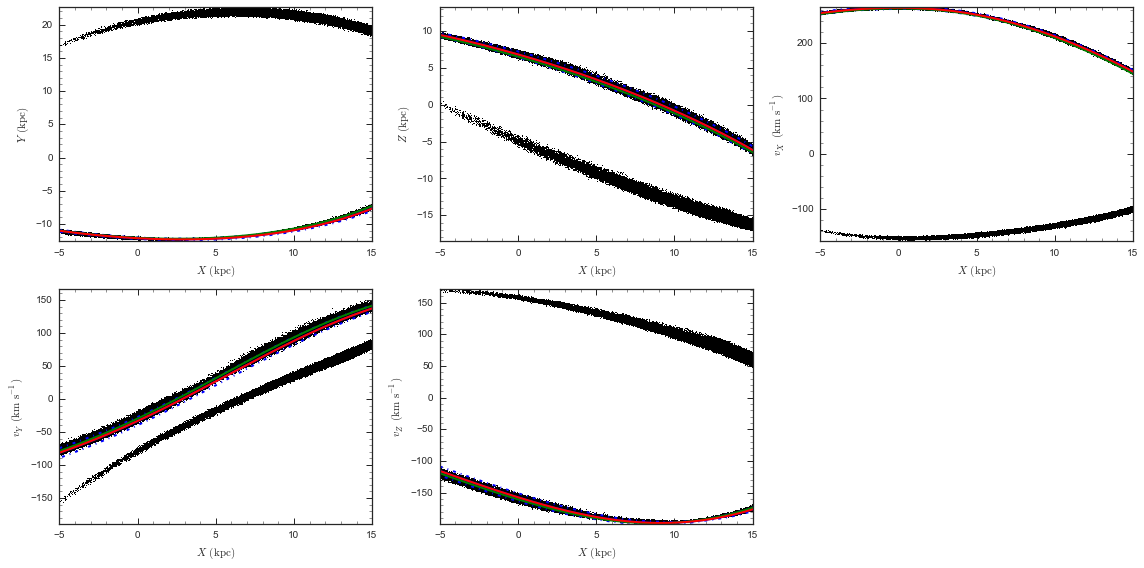

In [38]:
figsize(16,8)
subplot(2,3,1)
bovy_plot.bovy_plot(xv_1e8_peri[:,0],xv_1e8_peri[:,1],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Y\,(\mathrm{kpc})$',gcf=True,
                    xrange=[-5.,15.])
sdfl_unp_peri.plotTrack(d1='X',d2='Y',interp=True,color='b',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
sdfl_unp_peri.plotProgenitor(d1='X',d2='Y',color='g',overplot=True,lw=2.,scaleToPhysical=True)
sdfl_per_1e8_peri.plotTrack(d1='X',d2='Y',interp=True,color='r',spread=0,overplot=True,lw=2.,scaleToPhysical=True)
subplot(2,3,2)
bovy_plot.bovy_plot(xv_1e8_peri[:,0],xv_1e8_peri[:,2],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Z\,(\mathrm{kpc})$',gcf=True,
                    xrange=[-5.,15.])
sdfl_unp_peri.plotTrack(d1='X',d2='Z',interp=True,color='b',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
sdfl_unp_peri.plotProgenitor(d1='X',d2='Z',color='g',overplot=True,lw=2.,scaleToPhysical=True)
sdfl_per_1e8_peri.plotTrack(d1='X',d2='Z',interp=True,color='r',spread=0,overplot=True,lw=2.,scaleToPhysical=True)
subplot(2,3,3)
bovy_plot.bovy_plot(xv_1e8_peri[:,0],xv_1e8_peri[:,3],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$v_X\,(\mathrm{km\,s}^{-1})$',gcf=True,
                    xrange=[-5.,15.])
sdfl_unp_peri.plotTrack(d1='X',d2='vX',interp=True,color='b',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
sdfl_unp_peri.plotProgenitor(d1='X',d2='vX',color='g',overplot=True,lw=2.,scaleToPhysical=True)
sdfl_per_1e8_peri.plotTrack(d1='X',d2='vX',interp=True,color='r',spread=0,overplot=True,lw=2.,scaleToPhysical=True)
subplot(2,3,4)
bovy_plot.bovy_plot(xv_1e8_peri[:,0],xv_1e8_peri[:,4],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$v_Y\,(\mathrm{km\,s}^{-1})$',gcf=True,
                    xrange=[-5.,15.])
sdfl_unp_peri.plotTrack(d1='X',d2='vY',interp=True,color='b',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
sdfl_unp_peri.plotProgenitor(d1='X',d2='vY',color='g',overplot=True,lw=2.,scaleToPhysical=True)
sdfl_per_1e8_peri.plotTrack(d1='X',d2='vY',interp=True,color='r',spread=0,overplot=True,lw=2.,scaleToPhysical=True)
subplot(2,3,5)
bovy_plot.bovy_plot(xv_1e8_peri[:,0],xv_1e8_peri[:,5],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$v_Z\,(\mathrm{km\,s}^{-1})$',gcf=True,
                    xrange=[-5.,15.])
sdfl_unp_peri.plotTrack(d1='X',d2='vZ',interp=True,color='b',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
sdfl_unp_peri.plotProgenitor(d1='X',d2='vZ',color='g',overplot=True,lw=2.,scaleToPhysical=True)
sdfl_per_1e8_peri.plotTrack(d1='X',d2='vZ',interp=True,color='r',spread=0,overplot=True,lw=2.,scaleToPhysical=True)
tight_layout()

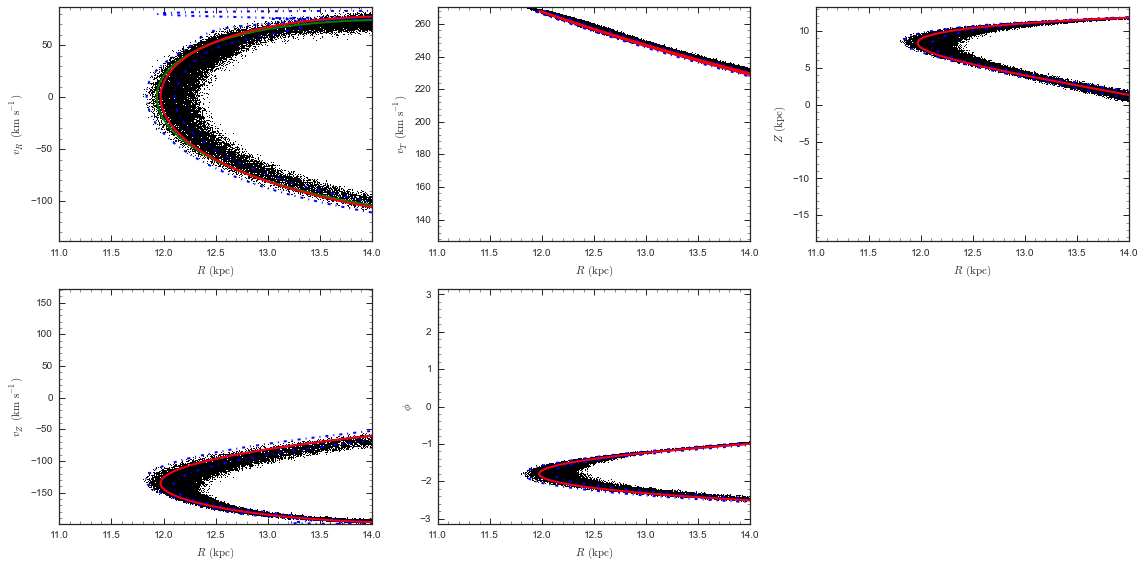

In [39]:
figsize(16,8)
subplot(2,3,1)
bovy_plot.bovy_plot(RvR_1e8_peri[:,0],RvR_1e8_peri[:,1],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$v_R\,(\mathrm{km\,s}^{-1})$',gcf=True,
                    xrange=[11.,14.])
sdfl_unp_peri.plotTrack(d1='R',d2='vR',interp=True,color='b',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
sdfl_unp_peri.plotProgenitor(d1='R',d2='vR',color='g',overplot=True,lw=2.,scaleToPhysical=True)
sdfl_per_1e8_peri.plotTrack(d1='R',d2='vR',interp=True,color='r',spread=0,overplot=True,lw=2.,scaleToPhysical=True)
subplot(2,3,2)
bovy_plot.bovy_plot(RvR_1e8_peri[:,0],RvR_1e8_peri[:,2],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$v_T\,(\mathrm{km\,s}^{-1})$',gcf=True,
                    xrange=[11.,14.])
sdfl_unp_peri.plotTrack(d1='R',d2='vT',interp=True,color='b',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
sdfl_per_1e8_peri.plotTrack(d1='R',d2='vT',interp=True,color='r',spread=0,overplot=True,lw=2.,scaleToPhysical=True)
subplot(2,3,3)
bovy_plot.bovy_plot(RvR_1e8_peri[:,0],RvR_1e8_peri[:,3],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$Z\,(\mathrm{kpc})$',gcf=True,
                    xrange=[11.,14.])
sdfl_unp_peri.plotTrack(d1='R',d2='Z',interp=True,color='b',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
sdfl_per_1e8_peri.plotTrack(d1='R',d2='Z',interp=True,color='r',spread=0,overplot=True,lw=2.,scaleToPhysical=True)
subplot(2,3,4)
bovy_plot.bovy_plot(RvR_1e8_peri[:,0],RvR_1e8_peri[:,4],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$v_Z\,(\mathrm{km\,s}^{-1})$',gcf=True,
                    xrange=[11.,14.])
sdfl_unp_peri.plotTrack(d1='R',d2='vZ',interp=True,color='b',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
sdfl_per_1e8_peri.plotTrack(d1='R',d2='vZ',interp=True,color='r',spread=0,overplot=True,lw=2.,scaleToPhysical=True)
subplot(2,3,5)
bovy_plot.bovy_plot(RvR_1e8_peri[:,0],RvR_1e8_peri[:,5],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$\phi$',gcf=True,
                    xrange=[11.,14.])
sdfl_unp_peri.plotTrack(d1='R',d2='phi',interp=True,color='b',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
sdfl_per_1e8_peri.plotTrack(d1='R',d2='phi',interp=True,color='r',spread=0,overplot=True,lw=2.,scaleToPhysical=True)
tight_layout()

Now we calculate the density near the gap in the perturbed and unperturbed case and compare it to the simulations. We compute the density from the model by sampling a large number of points from the model:

In [40]:
xrange=[-5.,15.]
numpy.random.seed(1)
xv_mock_per= sdfl_per_1e8_peri.sample(n=100000,xy=True).T
b,e= numpy.histogram(xv_mock_per[xv_mock_per[:,1]*8. < 5.,0]*8.,bins=101,normed=True,range=xrange)
t= ((numpy.roll(e,1)-e)/2.+e)[1:]
lspl= interpolate.UnivariateSpline(t,numpy.log(b),k=3,s=1.)
xs_per= numpy.linspace(t[0],t[-1],1001)
xps_per= numpy.exp(lspl(xs_per))
xps_per/= numpy.nansum(xps_per)*(xs_per[1]-xs_per[0])

In [41]:
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_unp= sdfl_unp_peri.sample(n=100000,xy=True).T
b,e= numpy.histogram(xv_mock_unp[xv_mock_unp[:,1]*8. < 5.,0]*8.,bins=101,normed=True,range=xrange)
t= ((numpy.roll(e,1)-e)/2.+e)[1:]
lspl= interpolate.UnivariateSpline(t,numpy.log(b),k=3,s=1.)
xs_unp= numpy.linspace(t[0],t[-1],1001)
xps_unp= numpy.exp(lspl(xs_unp))
xps_unp/= numpy.nansum(xps_unp)*(xs_unp[1]-xs_unp[0])

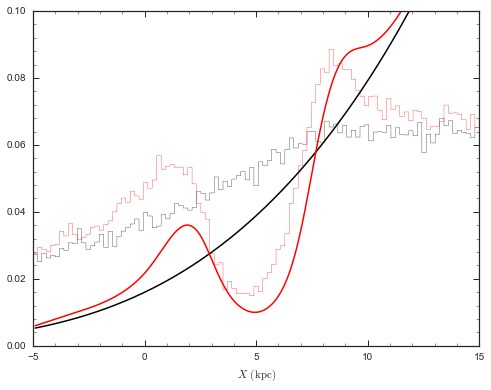

In [42]:
figsize(8,6)
raw= bovy_plot.bovy_hist(xv_unp_peri[xv_unp_peri[:,1] < 5.,0],bins=101,fc='0.5',ec='k',normed=True,histtype='step',
                         yrange=[0.,0.1],range=xrange,xlabel=r'$X\,(\mathrm{kpc})$')
raw= bovy_plot.bovy_hist(xv_1e8_peri[xv_1e8_peri[:,1] < 5.,0],bins=101,fc='0.5',ec='r',normed=True,histtype='step',
                         overplot=True,range=xrange)
bovy_plot.bovy_plot(xs_unp,xps_unp,'k-',lw=1.5,overplot=True)
bovy_plot.bovy_plot(xs_per,xps_per,'r-',lw=1.5,overplot=True)
#raw= bovy_plot.bovy_hist(xv_mock_unp[xv_mock_unp[:,1]*8. < 5.,0]*8.,bins=101,fc='0.5',ec='b',normed=True,histtype='step',
#                         overplot=True,range=[-5.,15.])

That looks good. How do we do relatively?

In [43]:
b,e= numpy.histogram(xv_1e8_peri[xv_1e8_peri[:,1] < 5.,0],bins=101,normed=True,range=xrange)
t= ((numpy.roll(e,1)-e)/2.+e)[1:]
lspl= interpolate.UnivariateSpline(t,numpy.log(b),k=3,s=1.)
xs_per_data= numpy.linspace(t[0],t[-1],1001)
xps_per_data= numpy.exp(lspl(xs_per_data))
xps_per_data/= numpy.nansum(xps_per)*(xs_per_data[1]-xs_per_data[0])
b,e= numpy.histogram(xv_unp_peri[xv_unp_peri[:,1] < 5.,0],bins=101,normed=True,range=xrange)
t= ((numpy.roll(e,1)-e)/2.+e)[1:]
lspl= interpolate.UnivariateSpline(t,numpy.log(b),k=3,s=1.)
xps_unp_data= numpy.exp(lspl(xs_per_data))
xps_unp_data/= numpy.nansum(xps_unp_data)*(xs_per_data[1]-xs_per_data[0])

<Container object of 1001 artists>

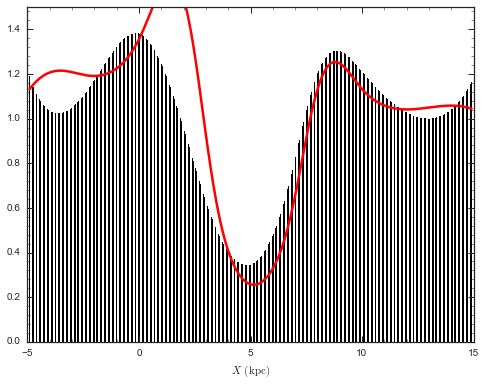

In [44]:
figsize(8,6)
bovy_plot.bovy_plot(xs_per,xps_per/xps_unp,'r-',lw=2.5,zorder=1,
                    yrange=[0.,1.5],xrange=xrange,xlabel=r'$X\,(\mathrm{kpc})$')
#bovy_plot.bovy_plot(xs_per_data,xps_per_data/xps_unp_data,'k-',lw=1.5,overplot=True)
bar(xs_per_data-(xs_per_data[1]-xs_per_data[0])/2.,xps_per_data/xps_unp_data,width=(xs_per_data[1]-xs_per_data[0])/2.,
    bottom=0.,ec='none',color='k',zorder=0)

Let's look at phase-space *differences*:

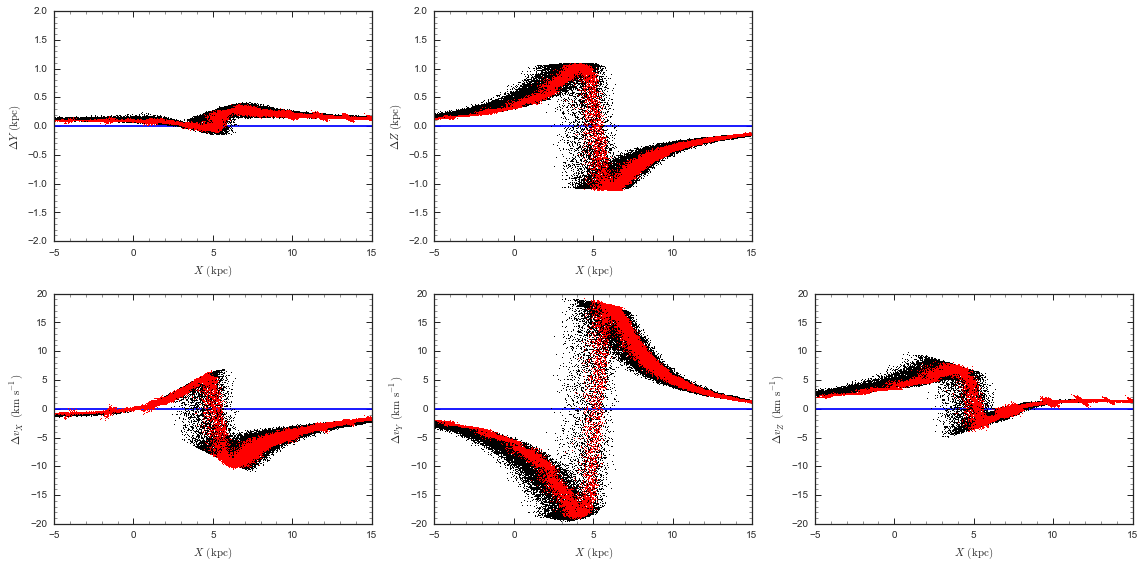

In [45]:
xs= numpy.linspace(-5.,15.,1001)
figsize(16,8)
subplot(2,3,1)
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    (sdfl_per_1e8_peri._ObsTrackXY[:,1]-sdfl_unp_peri._ObsTrackXY[:,1])*R0,
                    'b-',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$\Delta Y\,(\mathrm{kpc})$',gcf=True,yrange=[-2.,2.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),1]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),1],'k,')
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,1]-xv_mock_unp[:,1])*R0,'r,')
subplot(2,3,2)
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    (sdfl_per_1e8_peri._ObsTrackXY[:,2]-sdfl_unp_peri._ObsTrackXY[:,2])*R0,
                    'b-',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$\Delta Z\,(\mathrm{kpc})$',gcf=True,yrange=[-2.,2.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),2]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),2],'k,')
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,2]-xv_mock_unp[:,2])*R0,'r,')
subplot(2,3,4)
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    (sdfl_per_1e8_peri._ObsTrackXY[:,3]-sdfl_unp_peri._ObsTrackXY[:,3])*V0,
                    'b-',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$\Delta v_X\,(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-20.,20.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),3]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),3],'k,')
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,3]-xv_mock_unp[:,3])*V0,'r,')
subplot(2,3,5)
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    (sdfl_per_1e8_peri._ObsTrackXY[:,4]-sdfl_unp_peri._ObsTrackXY[:,4])*V0,
                    'b-',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$\Delta v_Y\,(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-20.,20.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),4]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),4],'k,')
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,4]-xv_mock_unp[:,4])*V0,'r,')
subplot(2,3,6)
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    (sdfl_per_1e8_peri._ObsTrackXY[:,5]-sdfl_unp_peri._ObsTrackXY[:,5])*V0,
                    'b-',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$\Delta v_Z\,(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-20.,20.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),5]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),5],'k,')
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,5]-xv_mock_unp[:,5])*V0,'r,')
tight_layout()

In [46]:
from matplotlib.ticker import NullFormatter
nullfmt= NullFormatter()
import matplotlib.lines as mlines
from matplotlib import gridspec

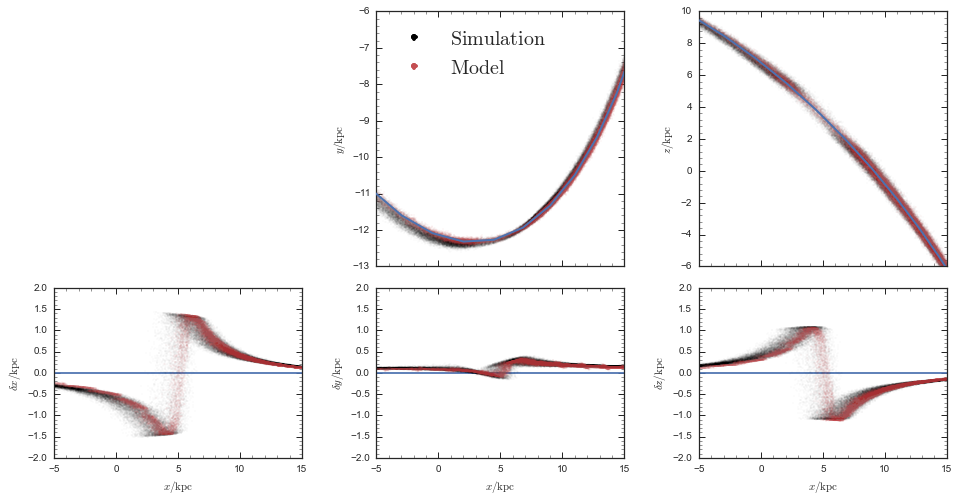

In [47]:
xs= numpy.linspace(-5.,15.,1001)
figsize(16,8)
gs=  gridspec.GridSpec(2,3,height_ratios=[1.5,1.],hspace=0.1,wspace=0.3)
gs2= gridspec.GridSpec(2,3,height_ratios=[1.5,1.],hspace=0.1,wspace=0.3)
subplot(gs[1])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,1]*R0,
                    '-',color=sns.color_palette()[0],
                    ylabel=r'$y/\mathrm{kpc}$',gcf=True,yrange=[-13.,-6.],
                   xrange=[-5.,15.],zorder=10,lw=2.)
plot(xv_1e8_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),1],'k.',ms=1,alpha=0.3)
plot(xv_mock_per[:,0]*R0,xv_mock_per[:,1]*R0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
pyplot.gca().xaxis.set_major_formatter(nullfmt)
pyplot.legend((mlines.Line2D([], [], color='k',marker='o',ls='none'),
               mlines.Line2D([], [], color=sns.color_palette()[2],marker='o',ls='none')),
              (r'$\mathrm{Simulation}$',
               r'$\mathrm{Model}$'),
               loc='upper left',#bbox_to_anchor=(.02,.02),
               numpoints=1,
               prop={'size':20},
               frameon=False)
subplot(gs[2])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,2]*R0,
                    '-',color=sns.color_palette()[0],
                    ylabel=r'$z/\mathrm{kpc}$',gcf=True,yrange=[-6.,10.],
                   xrange=[-5.,15.],zorder=10,lw=2.)
plot(xv_1e8_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),2],'k.',ms=1,alpha=0.3)
plot(xv_mock_per[:,0]*R0,xv_mock_per[:,2]*R0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
pyplot.gca().xaxis.set_major_formatter(nullfmt)
subplot(gs2[3])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,0]*R0*0.,
                    '-',xlabel=r'$x/\mathrm{kpc}$',color=sns.color_palette()[0],
                    ylabel=r'$\delta x/\mathrm{kpc}$',gcf=True,yrange=[-2.,2.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),0]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],
     'k.',ms=1,alpha=0.3)
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,0]-xv_mock_unp[:,0])*R0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
subplot(gs2[4])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,0]*R0*0.,
                    '-',xlabel=r'$x/\mathrm{kpc}$',color=sns.color_palette()[0],
                    ylabel=r'$\delta y/\mathrm{kpc}$',gcf=True,yrange=[-2.,2.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),1]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),1],
     'k.',ms=1,alpha=0.3)
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,1]-xv_mock_unp[:,1])*R0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
subplot(gs2[5])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,0]*R0*0.,
                    '-',xlabel=r'$x/\mathrm{kpc}$',color=sns.color_palette()[0],
                    ylabel=r'$\delta z/\mathrm{kpc}$',gcf=True,yrange=[-2.,2.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),2]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),2],
     'k.',ms=1,alpha=0.3)
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,2]-xv_mock_unp[:,2])*R0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)

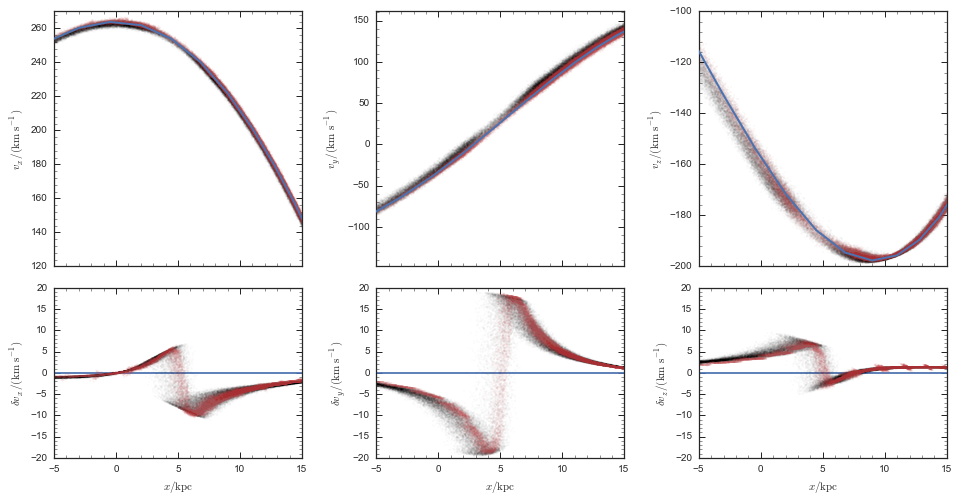

In [48]:
figsize(16,8)
gs=  gridspec.GridSpec(2,3,height_ratios=[1.5,1.],hspace=0.1,wspace=0.3)
gs2= gridspec.GridSpec(2,3,height_ratios=[1.5,1.],hspace=0.1,wspace=0.3)
subplot(gs[0])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,3]*V0,
                    '-',color=sns.color_palette()[0],
                    ylabel=r'$v_x/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[120.,270.],
                   xrange=[-5.,15.],zorder=10,lw=2.)
plot(xv_1e8_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),3],'k.',ms=1,alpha=0.3)
plot(xv_mock_per[:,0]*R0,xv_mock_per[:,3]*V0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
pyplot.gca().xaxis.set_major_formatter(nullfmt)
subplot(gs[1])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,4]*V0,
                    '-',color=sns.color_palette()[0],
                    ylabel=r'$v_y/(\mathrm{km\,s}^{-1})$',gcf=True,#yrange=[-20.,20.],
                   xrange=[-5.,15.],zorder=10,lw=2.)
plot(xv_1e8_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),4],'k.',ms=1,alpha=0.3)
plot(xv_mock_per[:,0]*R0,xv_mock_per[:,4]*V0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
pyplot.gca().xaxis.set_major_formatter(nullfmt)
subplot(gs[2])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,5]*V0,
                    '-',color=sns.color_palette()[0],
                    ylabel=r'$v_z/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-200.,-100.],
                   xrange=[-5.,15.],zorder=10,lw=2.)
plot(xv_1e8_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),5],'k.',ms=1,alpha=0.3)
plot(xv_mock_per[:,0]*R0,xv_mock_per[:,5]*V0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
pyplot.gca().xaxis.set_major_formatter(nullfmt)
subplot(gs2[3])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,0]*R0*0.,
                    '-',xlabel=r'$x/\mathrm{kpc}$',color=sns.color_palette()[0],
                    ylabel=r'$\delta v_x/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-20.,20.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),3]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),3],
     'k.',ms=1,alpha=0.3)
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,3]-xv_mock_unp[:,3])*V0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
subplot(gs2[4])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,0]*R0*0.,
                    '-',xlabel=r'$x/\mathrm{kpc}$',color=sns.color_palette()[0],
                    ylabel=r'$\delta v_y/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-20.,20.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),4]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),4],
     'k.',ms=1,alpha=0.3)
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,4]-xv_mock_unp[:,4])*V0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
subplot(gs2[5])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,0]*R0*0.,
                    '-',xlabel=r'$x/\mathrm{kpc}$',color=sns.color_palette()[0],
                    ylabel=r'$\delta v_z/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-20.,20.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),5]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),5],
     'k.',ms=1,alpha=0.3)
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,5]-xv_mock_unp[:,5])*V0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)

## Using Jason's custom stripping distributions

In [49]:
try:
    reload(custom_stripping_df)
except (NameError,ImportError):
    import custom_stripping_df

In [50]:
sdfl_unp_peri= custom_stripping_df.streamdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                        leading=False,nTrackChunks=26,nTrackIterations=1,
                        sigMeanOffset=4.5,
                        tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                        Vnorm=V0,Rnorm=R0)
sdfl_per_1e8_peri= custom_stripping_df.streamgapdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                                        leading=False,nTrackChunks=26,nTrackIterations=1,
                                                        sigMeanOffset=4.5,
                                                        tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                                        Vnorm=V0,Rnorm=R0,
                                                        impactb=0.,
                                                        subhalovel=numpy.array([6.82200571,132.7700529,149.4174464])/V0, # from Denis' email
                                                        timpact=0.88/bovy_conversion.time_in_Gyr(V0,R0),
                                                        impact_angle=-2.34,
                                                        GM=10.**-2./bovy_conversion.mass_in_1010msol(V0,R0),
                                                        rs=0.625/R0) 

In [51]:
xrange=[-5.,15.]
numpy.random.seed(1)
xv_mock_per= sdfl_per_1e8_peri.sample(n=100000,xy=True).T
b,e= numpy.histogram(xv_mock_per[xv_mock_per[:,1]*8. < 5.,0]*8.,bins=101,normed=True,range=xrange)
t= ((numpy.roll(e,1)-e)/2.+e)[1:]
lspl= interpolate.UnivariateSpline(t,numpy.log(b),k=3,s=1.5)
xs_per= numpy.linspace(t[0],t[-1],1001)
xps_per= numpy.exp(lspl(xs_per))
xps_per/= numpy.nansum(xps_per)*(xs_per[1]-xs_per[0])

In [52]:
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_unp= sdfl_unp_peri.sample(n=100000,xy=True).T
b,e= numpy.histogram(xv_mock_unp[xv_mock_unp[:,1]*8. < 5.,0]*8.,bins=101,normed=True,range=xrange)
t= ((numpy.roll(e,1)-e)/2.+e)[1:]
lspl= interpolate.UnivariateSpline(t,numpy.log(b),k=3,s=1.5)
xs_unp= numpy.linspace(t[0],t[-1],1001)
xps_unp= numpy.exp(lspl(xs_unp))
xps_unp/= numpy.nansum(xps_unp)*(xs_unp[1]-xs_unp[0])

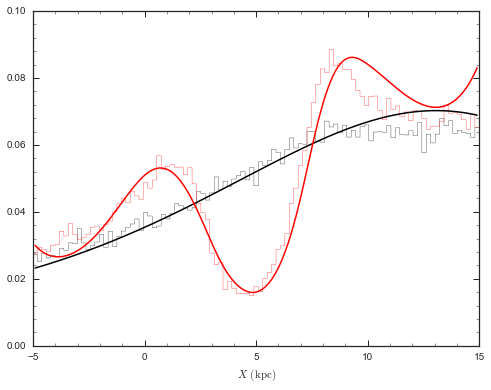

In [53]:
figsize(8,6)
raw= bovy_plot.bovy_hist(xv_unp_peri[xv_unp_peri[:,1] < 5.,0],bins=101,fc='0.5',ec='k',normed=True,histtype='step',
                         yrange=[0.,0.1],range=xrange,xlabel=r'$X\,(\mathrm{kpc})$')
raw= bovy_plot.bovy_hist(xv_1e8_peri[xv_1e8_peri[:,1] < 5.,0],bins=101,fc='0.5',ec='r',normed=True,histtype='step',
                         overplot=True,range=xrange)
bovy_plot.bovy_plot(xs_unp,xps_unp,'k-',lw=1.5,overplot=True)
bovy_plot.bovy_plot(xs_per,xps_per,'r-',lw=1.5,overplot=True)

In [54]:
b,e= numpy.histogram(xv_1e8_peri[xv_1e8_peri[:,1] < 5.,0],bins=101,normed=True,range=xrange)
t= ((numpy.roll(e,1)-e)/2.+e)[1:]
lspl= interpolate.UnivariateSpline(t,numpy.log(b),k=3,s=1.)
xs_per_data= numpy.linspace(t[0],t[-1],1001)
xps_per_data= numpy.exp(lspl(xs_per_data))
xps_per_data/= numpy.nansum(xps_per)*(xs_per_data[1]-xs_per_data[0])
b,e= numpy.histogram(xv_unp_peri[xv_unp_peri[:,1] < 5.,0],bins=101,normed=True,range=xrange)
t= ((numpy.roll(e,1)-e)/2.+e)[1:]
lspl= interpolate.UnivariateSpline(t,numpy.log(b),k=3,s=1.)
xps_unp_data= numpy.exp(lspl(xs_per_data))
xps_unp_data/= numpy.nansum(xps_unp_data)*(xs_per_data[1]-xs_per_data[0])

<Container object of 1001 artists>

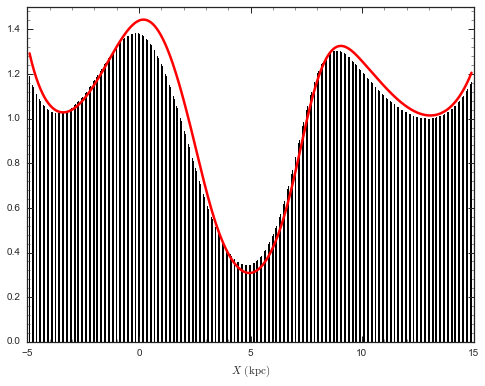

In [55]:
figsize(8,6)
bovy_plot.bovy_plot(xs_per,xps_per/xps_unp,'r-',lw=2.5,zorder=1,
                    yrange=[0.,1.5],xrange=xrange,xlabel=r'$X\,(\mathrm{kpc})$')
#bovy_plot.bovy_plot(xs_per_data,xps_per_data/xps_unp_data,'k-',lw=1.5,overplot=True)
bar(xs_per_data-(xs_per_data[1]-xs_per_data[0])/2.,xps_per_data/xps_unp_data,width=(xs_per_data[1]-xs_per_data[0])/2.,
    bottom=0.,ec='none',color='k',zorder=0)

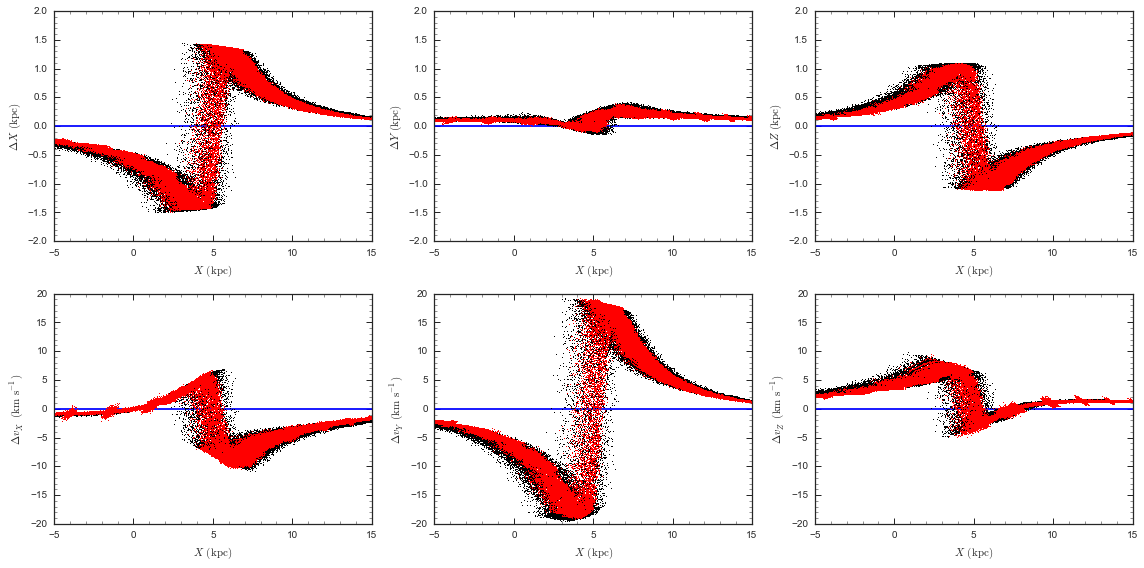

In [56]:
xs= numpy.linspace(-5.,15.,1001)
figsize(16,8)
subplot(2,3,1)
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    (sdfl_per_1e8_peri._ObsTrackXY[:,0]-sdfl_unp_peri._ObsTrackXY[:,0])*R0,
                    'b-',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$\Delta X\,(\mathrm{kpc})$',gcf=True,yrange=[-2.,2.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),0]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],'k,')
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,0]-xv_mock_unp[:,0])*R0,'r,')
subplot(2,3,2)
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    (sdfl_per_1e8_peri._ObsTrackXY[:,1]-sdfl_unp_peri._ObsTrackXY[:,1])*R0,
                    'b-',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$\Delta Y\,(\mathrm{kpc})$',gcf=True,yrange=[-2.,2.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),1]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),1],'k,')
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,1]-xv_mock_unp[:,1])*R0,'r,')
subplot(2,3,3)
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    (sdfl_per_1e8_peri._ObsTrackXY[:,2]-sdfl_unp_peri._ObsTrackXY[:,2])*R0,
                    'b-',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$\Delta Z\,(\mathrm{kpc})$',gcf=True,yrange=[-2.,2.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),2]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),2],'k,')
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,2]-xv_mock_unp[:,2])*R0,'r,')
subplot(2,3,4)
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    (sdfl_per_1e8_peri._ObsTrackXY[:,3]-sdfl_unp_peri._ObsTrackXY[:,3])*V0,
                    'b-',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$\Delta v_X\,(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-20.,20.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),3]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),3],'k,')
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,3]-xv_mock_unp[:,3])*V0,'r,')
subplot(2,3,5)
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    (sdfl_per_1e8_peri._ObsTrackXY[:,4]-sdfl_unp_peri._ObsTrackXY[:,4])*V0,
                    'b-',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$\Delta v_Y\,(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-20.,20.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),4]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),4],'k,')
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,4]-xv_mock_unp[:,4])*V0,'r,')
subplot(2,3,6)
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    (sdfl_per_1e8_peri._ObsTrackXY[:,5]-sdfl_unp_peri._ObsTrackXY[:,5])*V0,
                    'b-',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$\Delta v_Z\,(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-20.,20.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),5]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),5],'k,')
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,5]-xv_mock_unp[:,5])*V0,'r,')
tight_layout()

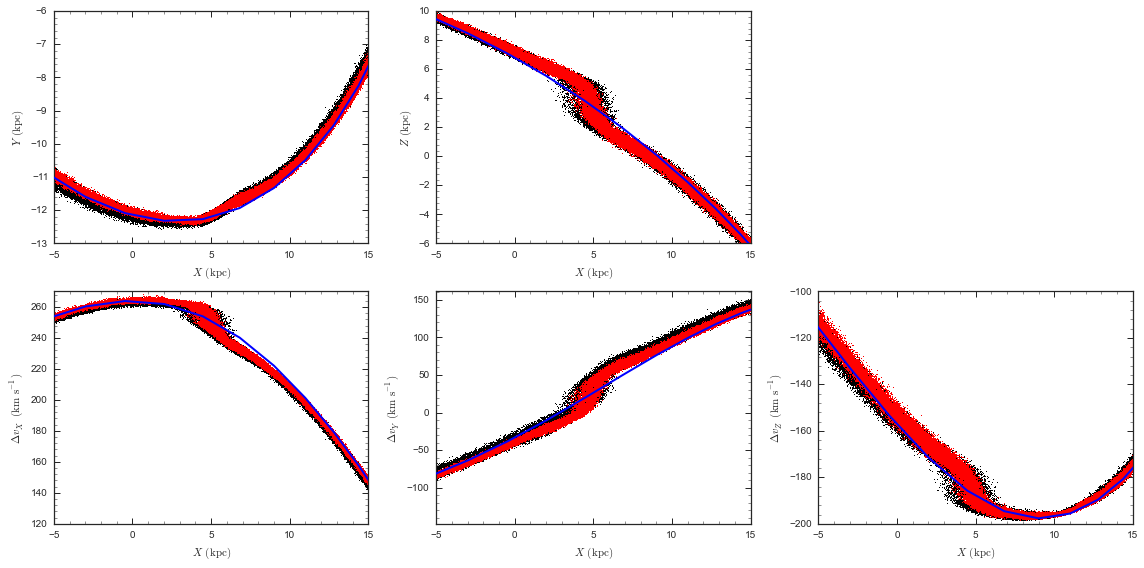

In [57]:
xs= numpy.linspace(-5.,15.,1001)
figsize(16,8)
subplot(2,3,1)
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,1]*R0,
                    'b-',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Y\,(\mathrm{kpc})$',gcf=True,yrange=[-13.,-6.],
                   xrange=[-5.,15.],zorder=10,lw=2.)
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),1],'k,')
plot(xv_mock_unp[:,0]*R0,xv_mock_per[:,1]*R0,'r,')
subplot(2,3,2)
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,2]*R0,
                    'b-',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Z\,(\mathrm{kpc})$',gcf=True,yrange=[-6.,10.],
                   xrange=[-5.,15.],zorder=10,lw=2.)
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),2],'k,')
plot(xv_mock_unp[:,0]*R0,xv_mock_per[:,2]*R0,'r,')
subplot(2,3,4)
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,3]*V0,
                    'b-',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$\Delta v_X\,(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[120.,270.],
                   xrange=[-5.,15.],zorder=10,lw=2.)
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),3],'k,')
plot(xv_mock_unp[:,0]*R0,xv_mock_per[:,3]*V0,'r,')
subplot(2,3,5)
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,4]*V0,
                    'b-',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$\Delta v_Y\,(\mathrm{km\,s}^{-1})$',gcf=True,#yrange=[-20.,20.],
                   xrange=[-5.,15.],zorder=10,lw=2.)
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),4],'k,')
plot(xv_mock_unp[:,0]*R0,xv_mock_per[:,4]*V0,'r,')
subplot(2,3,6)
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,5]*V0,
                    'b-',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$\Delta v_Z\,(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-200.,-100.],
                   xrange=[-5.,15.],zorder=10,lw=2.)
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),5],'k,')
plot(xv_mock_unp[:,0]*R0,xv_mock_per[:,5]*V0,'r,')
tight_layout()

## Pretty plots for the paper

In [58]:
import seaborn as sns
#a = sns.plotting_context('ipython')
sns.set_style('ticks',
              {'xtick.direction': u'in',
               'ytick.direction': u'in',
               'axes.labelsize': 18.0,
               'axes.titlesize': 18.0,
               'figure.figsize': array([ 6.64,  4.  ]),
               'grid.linewidth': 2.0,
               'legend.fontsize': 18.0,
               'lines.linewidth': 2.0,
               'lines.markeredgewidth': 0.0,
               'lines.markersize': 14.0,
               'patch.linewidth': 0.6,
               'xtick.labelsize': 16.0,
               'xtick.major.pad': 14.0,
               'xtick.major.width': 2.0,
               'xtick.minor.width': 1.0,
               'ytick.labelsize': 16.0,
               'ytick.major.pad': 14.0,
               'ytick.major.width': 2.0,})
from matplotlib.ticker import NullFormatter
nullfmt= NullFormatter()
import matplotlib.lines as mlines
from matplotlib import gridspec
bovy_plot.bovy_print(axes_labelsize=18.,text_fontsize=12.,xtick_labelsize=16.,ytick_labelsize=16.,
                    )

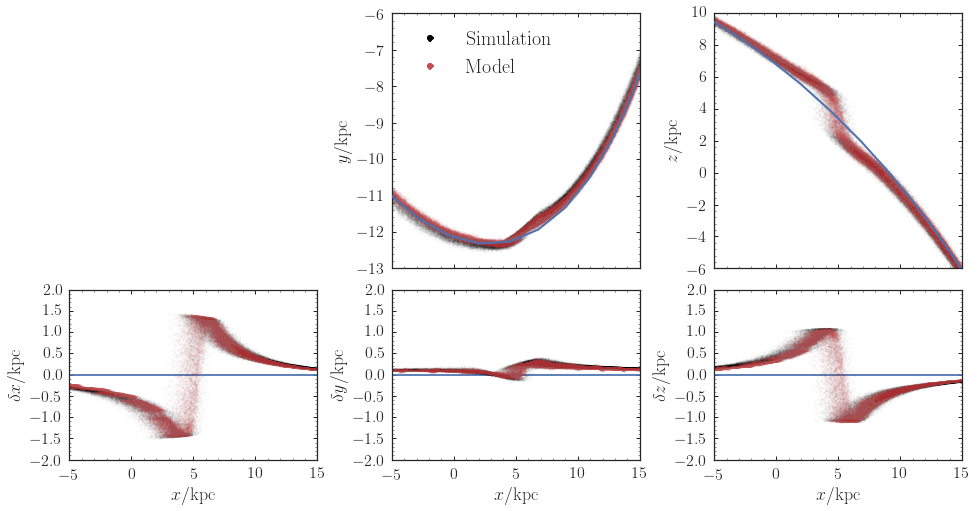

In [59]:
xs= numpy.linspace(-5.,15.,1001)
figsize(16,8)
gs=  gridspec.GridSpec(2,3,height_ratios=[1.5,1.],hspace=0.1,wspace=0.3)
gs2= gridspec.GridSpec(2,3,height_ratios=[1.5,1.],hspace=0.1,wspace=0.3)
subplot(gs[1])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,1]*R0,
                    '-',color=sns.color_palette()[0],
                    ylabel=r'$y/\mathrm{kpc}$',gcf=True,yrange=[-13.,-6.],
                   xrange=[-5.,15.],zorder=10,lw=2.)
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),1],'k.',ms=1,alpha=0.3)
plot(xv_mock_unp[:,0]*R0,xv_mock_per[:,1]*R0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
pyplot.gca().xaxis.set_major_formatter(nullfmt)
pyplot.legend((mlines.Line2D([], [], color='k',marker='o',ls='none'),
               mlines.Line2D([], [], color=sns.color_palette()[2],marker='o',ls='none')),
              (r'$\mathrm{Simulation}$',
               r'$\mathrm{Model}$'),
               loc='upper left',#bbox_to_anchor=(.02,.02),
               numpoints=1,
               prop={'size':20},
               frameon=False)
subplot(gs[2])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,2]*R0,
                    '-',color=sns.color_palette()[0],
                    ylabel=r'$z/\mathrm{kpc}$',gcf=True,yrange=[-6.,10.],
                   xrange=[-5.,15.],zorder=10,lw=2.)
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),2],'k.',ms=1,alpha=0.3)
plot(xv_mock_unp[:,0]*R0,xv_mock_per[:,2]*R0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
pyplot.gca().xaxis.set_major_formatter(nullfmt)
subplot(gs2[3])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,0]*R0*0.,
                    '-',xlabel=r'$x/\mathrm{kpc}$',color=sns.color_palette()[0],
                    ylabel=r'$\delta x/\mathrm{kpc}$',gcf=True,yrange=[-2.,2.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),0]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],
     'k.',ms=1,alpha=0.3)
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,0]-xv_mock_unp[:,0])*R0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
subplot(gs2[4])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,0]*R0*0.,
                    '-',xlabel=r'$x/\mathrm{kpc}$',color=sns.color_palette()[0],
                    ylabel=r'$\delta y/\mathrm{kpc}$',gcf=True,yrange=[-2.,2.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),1]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),1],
     'k.',ms=1,alpha=0.3)
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,1]-xv_mock_unp[:,1])*R0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
subplot(gs2[5])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,0]*R0*0.,
                    '-',xlabel=r'$x/\mathrm{kpc}$',color=sns.color_palette()[0],
                    ylabel=r'$\delta z/\mathrm{kpc}$',gcf=True,yrange=[-2.,2.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),2]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),2],
     'k.',ms=1,alpha=0.3)
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,2]-xv_mock_unp[:,2])*R0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
plt.savefig('../paper/config_position.png',bbox_inches='tight',dpi=500)

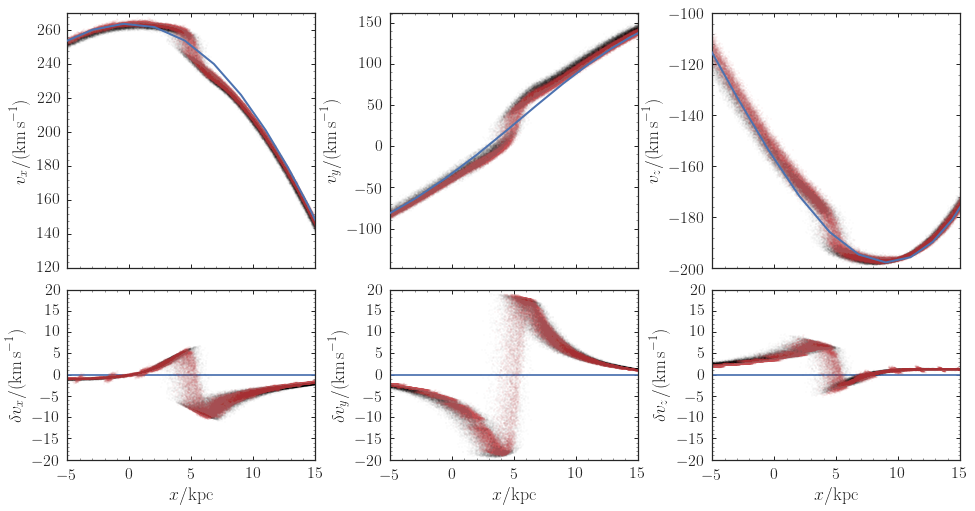

In [60]:
figsize(16,8)
gs=  gridspec.GridSpec(2,3,height_ratios=[1.5,1.],hspace=0.1,wspace=0.3)
gs2= gridspec.GridSpec(2,3,height_ratios=[1.5,1.],hspace=0.1,wspace=0.3)
subplot(gs[0])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,3]*V0,
                    '-',color=sns.color_palette()[0],
                    ylabel=r'$v_x/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[120.,270.],
                   xrange=[-5.,15.],zorder=10,lw=2.)
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),3],'k.',ms=1,alpha=0.3)
plot(xv_mock_unp[:,0]*R0,xv_mock_per[:,3]*V0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
pyplot.gca().xaxis.set_major_formatter(nullfmt)
subplot(gs[1])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,4]*V0,
                    '-',color=sns.color_palette()[0],
                    ylabel=r'$v_y/(\mathrm{km\,s}^{-1})$',gcf=True,#yrange=[-20.,20.],
                   xrange=[-5.,15.],zorder=10,lw=2.)
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),4],'k.',ms=1,alpha=0.3)
plot(xv_mock_unp[:,0]*R0,xv_mock_per[:,4]*V0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
pyplot.gca().xaxis.set_major_formatter(nullfmt)
subplot(gs[2])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,5]*V0,
                    '-',color=sns.color_palette()[0],
                    ylabel=r'$v_z/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-200.,-100.],
                   xrange=[-5.,15.],zorder=10,lw=2.)
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),5],'k.',ms=1,alpha=0.3)
plot(xv_mock_unp[:,0]*R0,xv_mock_per[:,5]*V0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
pyplot.gca().xaxis.set_major_formatter(nullfmt)
subplot(gs2[3])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,0]*R0*0.,
                    '-',xlabel=r'$x/\mathrm{kpc}$',color=sns.color_palette()[0],
                    ylabel=r'$\delta v_x/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-20.,20.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),3]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),3],
     'k.',ms=1,alpha=0.3)
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,3]-xv_mock_unp[:,3])*V0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
subplot(gs2[4])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,0]*R0*0.,
                    '-',xlabel=r'$x/\mathrm{kpc}$',color=sns.color_palette()[0],
                    ylabel=r'$\delta v_y/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-20.,20.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),4]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),4],
     'k.',ms=1,alpha=0.3)
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,4]-xv_mock_unp[:,4])*V0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
subplot(gs2[5])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,0]*R0*0.,
                    '-',xlabel=r'$x/\mathrm{kpc}$',color=sns.color_palette()[0],
                    ylabel=r'$\delta v_z/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-20.,20.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),5]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),5],
     'k.',ms=1,alpha=0.3)
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,5]-xv_mock_unp[:,5])*V0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
plt.savefig('../paper/config_velocity.png',bbox_inches='tight',dpi=500)

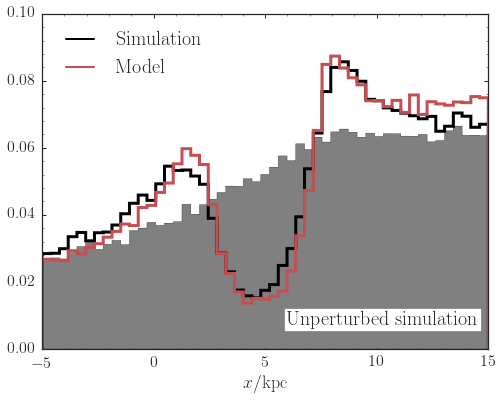

In [61]:
figsize(8,6)
bins=51
line1= bovy_plot.bovy_hist(xv_unp_peri[xv_unp_peri[:,1] < 5.,0],bins=bins,fc='0.5',ec=None,normed=True,histtype='stepfilled',
                         yrange=[0.,0.1],range=xrange,xlabel=r'$x/\mathrm{kpc}$')
line2= bovy_plot.bovy_hist(xv_1e8_peri[xv_1e8_peri[:,1] < 5.,0],bins=bins,fc='0.5',ec='k',
                         normed=True,histtype='step',lw=3.,
                         overplot=True,range=xrange)
raw= bovy_plot.bovy_hist(xv_mock_per[xv_mock_per[:,1]*8. < 5.,0]*8.,bins=bins,color=sns.color_palette()[2],
                         normed=True,histtype='step',lw=3.,
                         overplot=True,range=xrange)
pyplot.legend((mlines.Line2D([], [], color='k',ls='-',lw=2),
               mlines.Line2D([], [], color=sns.color_palette()[2],ls='-',lw=2)),
              (r'$\mathrm{Simulation}$',
               r'$\mathrm{Model}$'),
               loc='upper left',#bbox_to_anchor=(.02,.02),
               numpoints=2,
               prop={'size':20},
               frameon=False)
bovy_plot.bovy_text(6.,0.007,r'$\mathrm{Unperturbed\ simulation}$',
                   backgroundcolor='w',size=20.)
plt.savefig('../paper/config_density.png',bbox_inches='tight',dpi=500)

## Not as a function of unperturbed $X$

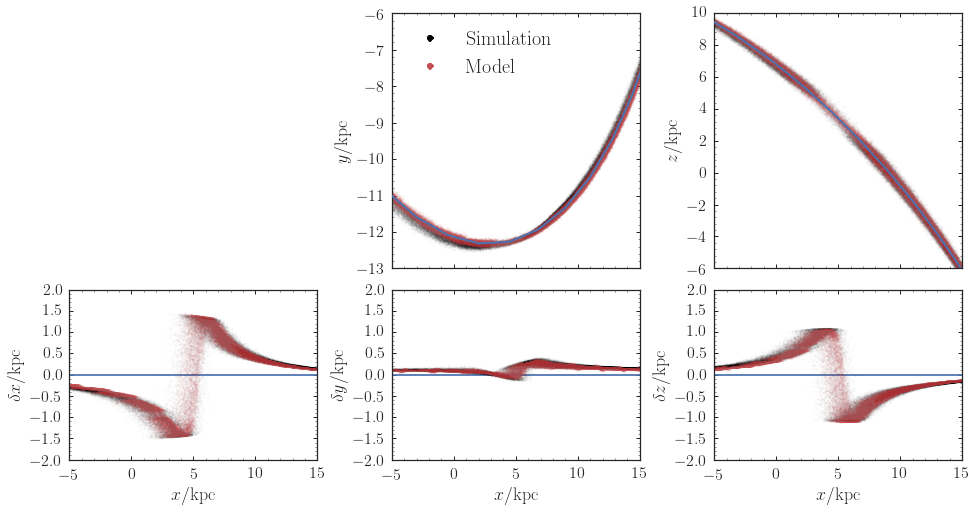

In [62]:
xs= numpy.linspace(-5.,15.,1001)
figsize(16,8)
gs=  gridspec.GridSpec(2,3,height_ratios=[1.5,1.],hspace=0.1,wspace=0.3)
gs2= gridspec.GridSpec(2,3,height_ratios=[1.5,1.],hspace=0.1,wspace=0.3)
subplot(gs[1])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,1]*R0,
                    '-',color=sns.color_palette()[0],
                    ylabel=r'$y/\mathrm{kpc}$',gcf=True,yrange=[-13.,-6.],
                   xrange=[-5.,15.],zorder=10,lw=2.)
plot(xv_1e8_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),1],'k.',ms=1,alpha=0.3)
plot(xv_mock_per[:,0]*R0,xv_mock_per[:,1]*R0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
pyplot.gca().xaxis.set_major_formatter(nullfmt)
pyplot.legend((mlines.Line2D([], [], color='k',marker='o',ls='none'),
               mlines.Line2D([], [], color=sns.color_palette()[2],marker='o',ls='none')),
              (r'$\mathrm{Simulation}$',
               r'$\mathrm{Model}$'),
               loc='upper left',#bbox_to_anchor=(.02,.02),
               numpoints=1,
               prop={'size':20},
               frameon=False)
subplot(gs[2])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,2]*R0,
                    '-',color=sns.color_palette()[0],
                    ylabel=r'$z/\mathrm{kpc}$',gcf=True,yrange=[-6.,10.],
                   xrange=[-5.,15.],zorder=10,lw=2.)
plot(xv_1e8_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),2],'k.',ms=1,alpha=0.3)
plot(xv_mock_per[:,0]*R0,xv_mock_per[:,2]*R0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
pyplot.gca().xaxis.set_major_formatter(nullfmt)
subplot(gs2[3])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,0]*R0*0.,
                    '-',xlabel=r'$x/\mathrm{kpc}$',color=sns.color_palette()[0],
                    ylabel=r'$\delta x/\mathrm{kpc}$',gcf=True,yrange=[-2.,2.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),0]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],
     'k.',ms=1,alpha=0.3)
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,0]-xv_mock_unp[:,0])*R0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
subplot(gs2[4])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,0]*R0*0.,
                    '-',xlabel=r'$x/\mathrm{kpc}$',color=sns.color_palette()[0],
                    ylabel=r'$\delta y/\mathrm{kpc}$',gcf=True,yrange=[-2.,2.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),1]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),1],
     'k.',ms=1,alpha=0.3)
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,1]-xv_mock_unp[:,1])*R0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
subplot(gs2[5])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,0]*R0*0.,
                    '-',xlabel=r'$x/\mathrm{kpc}$',color=sns.color_palette()[0],
                    ylabel=r'$\delta z/\mathrm{kpc}$',gcf=True,yrange=[-2.,2.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),2]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),2],
     'k.',ms=1,alpha=0.3)
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,2]-xv_mock_unp[:,2])*R0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)

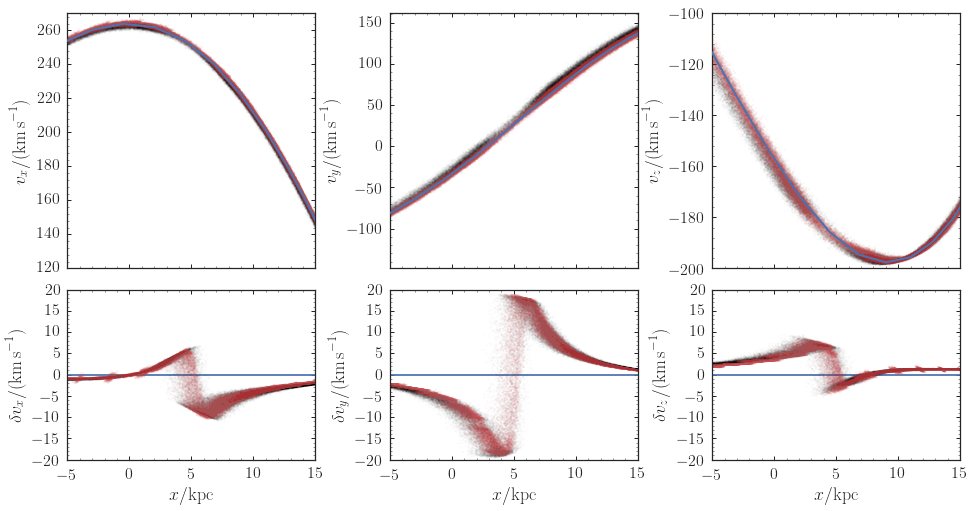

In [63]:
figsize(16,8)
gs=  gridspec.GridSpec(2,3,height_ratios=[1.5,1.],hspace=0.1,wspace=0.3)
gs2= gridspec.GridSpec(2,3,height_ratios=[1.5,1.],hspace=0.1,wspace=0.3)
subplot(gs[0])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,3]*V0,
                    '-',color=sns.color_palette()[0],
                    ylabel=r'$v_x/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[120.,270.],
                   xrange=[-5.,15.],zorder=10,lw=2.)
plot(xv_1e8_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),3],'k.',ms=1,alpha=0.3)
plot(xv_mock_per[:,0]*R0,xv_mock_per[:,3]*V0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
pyplot.gca().xaxis.set_major_formatter(nullfmt)
subplot(gs[1])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,4]*V0,
                    '-',color=sns.color_palette()[0],
                    ylabel=r'$v_y/(\mathrm{km\,s}^{-1})$',gcf=True,#yrange=[-20.,20.],
                   xrange=[-5.,15.],zorder=10,lw=2.)
plot(xv_1e8_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),4],'k.',ms=1,alpha=0.3)
plot(xv_mock_per[:,0]*R0,xv_mock_per[:,4]*V0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
pyplot.gca().xaxis.set_major_formatter(nullfmt)
subplot(gs[2])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,5]*V0,
                    '-',color=sns.color_palette()[0],
                    ylabel=r'$v_z/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-200.,-100.],
                   xrange=[-5.,15.],zorder=10,lw=2.)
plot(xv_1e8_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),5],'k.',ms=1,alpha=0.3)
plot(xv_mock_per[:,0]*R0,xv_mock_per[:,5]*V0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
pyplot.gca().xaxis.set_major_formatter(nullfmt)
subplot(gs2[3])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,0]*R0*0.,
                    '-',xlabel=r'$x/\mathrm{kpc}$',color=sns.color_palette()[0],
                    ylabel=r'$\delta v_x/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-20.,20.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),3]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),3],
     'k.',ms=1,alpha=0.3)
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,3]-xv_mock_unp[:,3])*V0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
subplot(gs2[4])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,0]*R0*0.,
                    '-',xlabel=r'$x/\mathrm{kpc}$',color=sns.color_palette()[0],
                    ylabel=r'$\delta v_y/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-20.,20.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),4]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),4],
     'k.',ms=1,alpha=0.3)
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,4]-xv_mock_unp[:,4])*V0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)
subplot(gs2[5])
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    sdfl_unp_peri._ObsTrackXY[:,0]*R0*0.,
                    '-',xlabel=r'$x/\mathrm{kpc}$',color=sns.color_palette()[0],
                    ylabel=r'$\delta v_z/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-20.,20.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),5]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),5],
     'k.',ms=1,alpha=0.3)
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,5]-xv_mock_unp[:,5])*V0,'.',color=sns.color_palette()[2],ms=1.5,alpha=0.3)